In [1]:
from clearml.task import Task
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_style("whitegrid")
sns.set_palette("muted")

# Get tasks

In [2]:
tasks = Task.get_tasks(project_name="lie-pose-net", task_filter={"system_tags": ["-archived"]})

In [3]:
completed_tasks = [x for x in tasks if x.status == "completed" or x.status == "published"]

In [4]:
completed_tasks[0].get_parameters()

{'General/batch_size': '64',
 'General/use_test': 'True',
 'General/num_workers': '4',
 'General/image_size': '256',
 'General/scene': 'fire',
 'General/data_path': '/media/mikhail/Data3T/7scenes',
 'General/name': 'PoseNet',
 'General/feature_extractor/pretrained': 'True',
 'General/criterion/name': 'SE3Criterion',
 'General/criterion/rotation_koef': '-3.0',
 'General/criterion/translation_koef': '-3.0',
 'General/feature_dimension': '2048',
 'General/drop_rate': '0',
 'General/optimizer/betas': '0.9 0.999',
 'General/optimizer/lr': '0.0001',
 'General/optimizer/weight_decay': '0.0005',
 'General/scheduler/step_size': '20',
 'General/scheduler/gamma': '0.5',
 'General/bias': 'True',
 'General/activation': 'tanh',
 'General/pretrained': 'True',
 'General/max_epochs': '1',
 'General/checkpoint_every_n_val_epochs': '10',
 'General/gpus': '1',
 'General/check_val_every_n_epoch': '2'}

In [5]:
completed_tasks[0].get_last_scalar_metrics()

{'hp_metric': {'hp_metric': {'last': -1.0, 'min': -1.0, 'max': -1.0}},
 'median_position_error': {'median_position_error': {'last': 0.49089682,
   'min': 0.49089682,
   'max': 0.49089682}},
 'epoch': {'epoch': {'last': 0.0, 'min': 0.0, 'max': 0.0}},
 'median_rotation_error': {'median_rotation_error': {'last': 16.673971,
   'min': 16.673971,
   'max': 16.673971}},
 'test_loss': {'test_loss': {'last': -4.1197333,
   'min': -4.1197333,
   'max': -4.1197333}},
 'position_error': {'position_error': {'last': 0.50244135,
   'min': 0.50244135,
   'max': 0.50244135}},
 'rotation_error': {'rotation_error': {'last': 20.484383,
   'min': 20.484383,
   'max': 20.484383}}}

# Analyse lie pose net

In [6]:
task_dict = {x.id: x for x in completed_tasks}

In [7]:
task_data = pd.DataFrame({
    "id": [x.id for x in completed_tasks],
    "criterion": [x.get_parameters()["General/criterion/name"] for x in completed_tasks],
    "epoch": [x.get_last_scalar_metrics()["epoch"]["epoch"]["last"] for x in completed_tasks],
    "tags": [x.get_tags() for x in completed_tasks],
    "scene": [x.get_parameters()["General/scene"] for x in completed_tasks]
})

In [8]:
task_data

,id,criterion,epoch,tags,scene
0,f01fb592f3e24112a523856a01384157,SE3Criterion,0.0,[],fire
1,709cb7f341b74cf4b70c778465f6f1d4,SE3Criterion,99.0,[good],fire
2,7311ce5ca25d4149b538ea7c2787af31,SE3Criterion,99.0,[good],chess
3,2ca30c315011418688b544ac7faab15e,SE3Criterion,99.0,[good],heads
4,72de21bc9cb9406eac80815afc96e461,SE3Criterion,99.0,[good],office
5,a5fa8425e9ff41fcb262fc4b4442459b,SE3Criterion,99.0,[],redkitchen
6,88d05e64f59447c7a066b3549a872022,SE3Criterion,99.0,[good],pumpkin
7,15b63a4f6dbb4019893752574112bb65,SE3Criterion,99.0,[good],stairs
8,21a1398c2ef34f48a80697012e71f77a,PoseNetCriterion,99.0,[good],fire
9,75910c48878e4f00a86e31323641f836,PoseNetCriterion,99.0,[good],stairs


In [9]:
def filter_task_data(data):
    indexes = data["epoch"] >= 99
    indexes &= (data["criterion"] == "SE3Criterion") | (data["criterion"] == "PoseNetCriterion")
    indexes &= ["good" in x for x in data["tags"]]
    return data[indexes]

In [10]:
filtred_task_data = filter_task_data(task_data)
filtred_task_data

,id,criterion,epoch,tags,scene
1,709cb7f341b74cf4b70c778465f6f1d4,SE3Criterion,99.0,[good],fire
2,7311ce5ca25d4149b538ea7c2787af31,SE3Criterion,99.0,[good],chess
3,2ca30c315011418688b544ac7faab15e,SE3Criterion,99.0,[good],heads
4,72de21bc9cb9406eac80815afc96e461,SE3Criterion,99.0,[good],office
6,88d05e64f59447c7a066b3549a872022,SE3Criterion,99.0,[good],pumpkin
7,15b63a4f6dbb4019893752574112bb65,SE3Criterion,99.0,[good],stairs
8,21a1398c2ef34f48a80697012e71f77a,PoseNetCriterion,99.0,[good],fire
9,75910c48878e4f00a86e31323641f836,PoseNetCriterion,99.0,[good],stairs
10,9ea1ba38216e408987aecdfbdf950ae6,PoseNetCriterion,99.0,[good],chess
11,44d9030cf4ca45f5a8aa98307806f505,PoseNetCriterion,99.0,[good],pumpkin


In [11]:
def get_metric_data(scalars, metric):
    data = pd.DataFrame({
        metric: scalars[metric][metric]["y"], 
        "iteration": scalars[metric][metric]["x"]
    }).set_index("iteration")
    return data

def get_several_metric_data(scalars, metrics):
    data = get_metric_data(scalars, metrics[0])
    for metric in metrics[1:]:
        data = data.join(get_metric_data(scalars, metric))
    return data

def add_column(data, column, value):
    data_length = len(data.index)
    data[column] = pd.Series([value for _ in range(data_length)])
    return data

In [12]:
experiment_data = pd.DataFrame()
for task_row in filtred_task_data.iloc:
    task = task_dict[task_row.id]
    reported_scalars = task.get_reported_scalars()
    data = get_several_metric_data(reported_scalars, ["epoch", "median_position_error", 
                                                                 "median_rotation_error", "val_loss"])
    data = data[~data.isnull().any(axis=1)].reset_index()
    data = add_column(data, "scene", task_row.scene)
    data = add_column(data, "criterion", task_row.criterion)
    data = add_column(data, "id", task_row.criterion)
    experiment_data = experiment_data.append(data)

<AxesSubplot:xlabel='epoch', ylabel='median_position_error'>

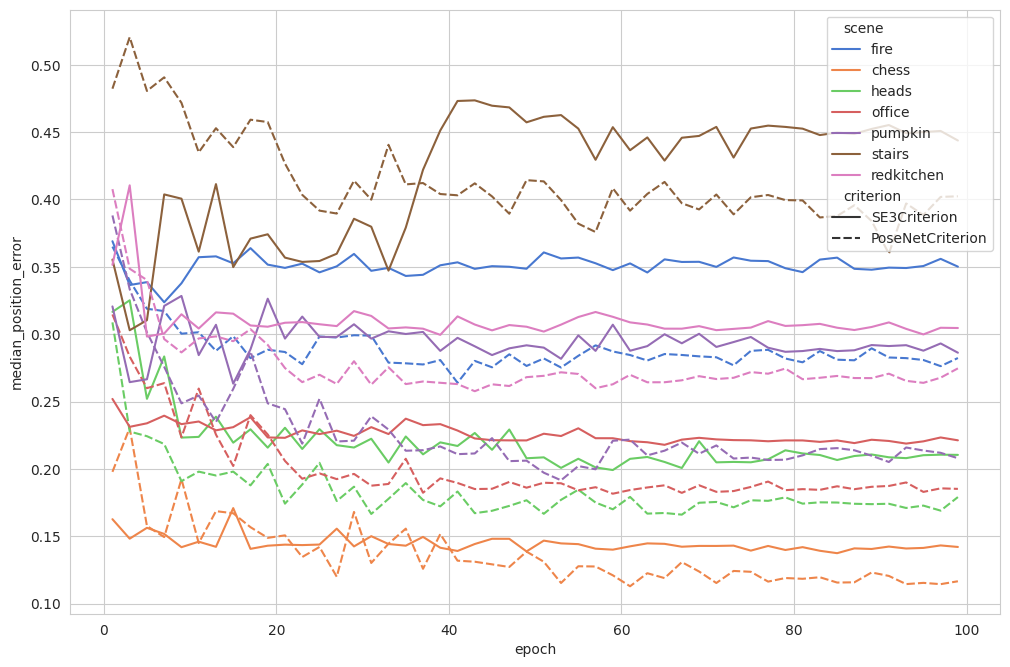

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=100)
sns.lineplot(data=experiment_data, x="epoch", y="median_position_error", ax=ax, hue="scene", style="criterion")

<AxesSubplot:xlabel='epoch', ylabel='median_rotation_error'>

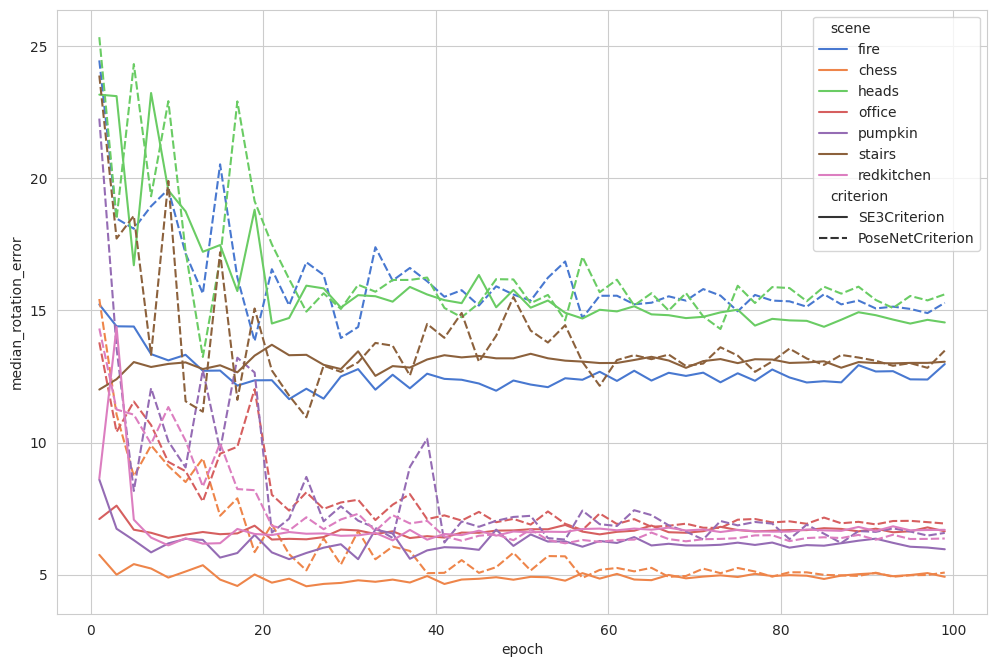

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=100)
sns.lineplot(data=experiment_data, x="epoch", y="median_rotation_error", ax=ax, hue="scene", style="criterion")

<AxesSubplot:xlabel='epoch', ylabel='median_position_error'>

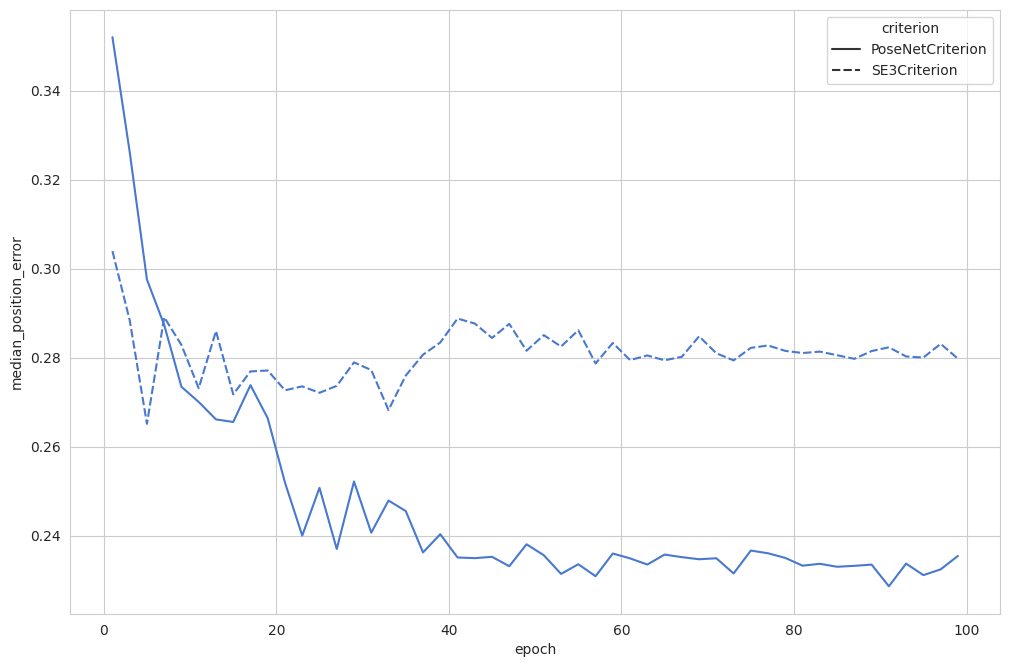

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=100)
mean_trajectory_data = experiment_data.pivot_table(index=["epoch", "criterion"], values=["median_rotation_error", 
                                                                      "median_position_error"])
sns.lineplot(data=mean_trajectory_data, x="epoch", y="median_position_error", ax=ax, style="criterion")

<AxesSubplot:xlabel='epoch', ylabel='median_rotation_error'>

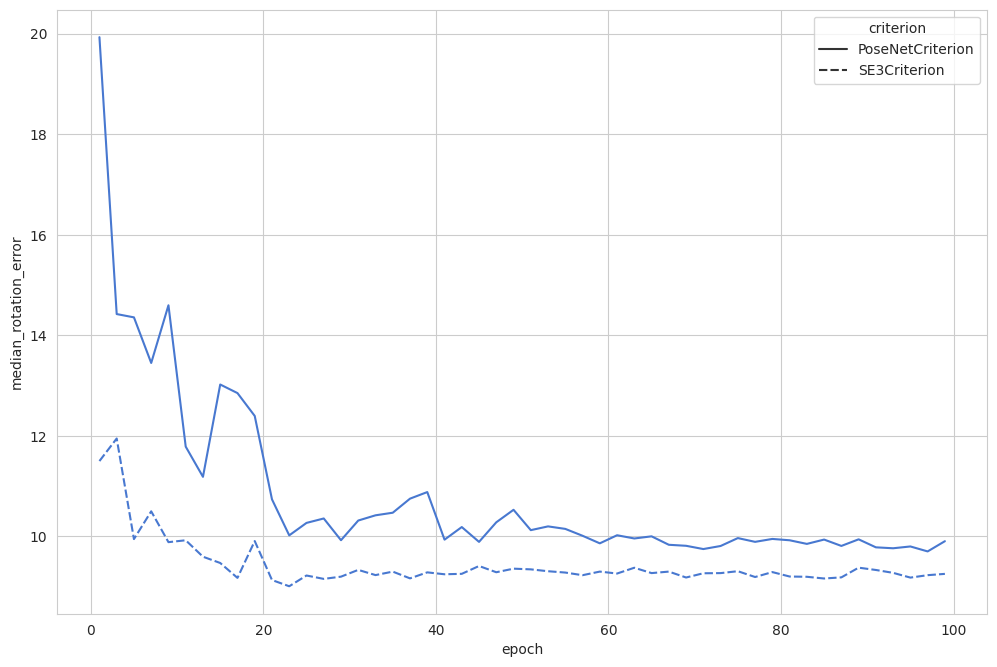

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=100)
sns.lineplot(data=mean_trajectory_data, x="epoch", y="median_rotation_error", ax=ax, style="criterion")

## 20 epochs

In [30]:
data_20epoch = experiment_data[(experiment_data["epoch"] < 25) & (experiment_data["epoch"] > 15)]

<AxesSubplot:xlabel='scene', ylabel='median_rotation_error'>

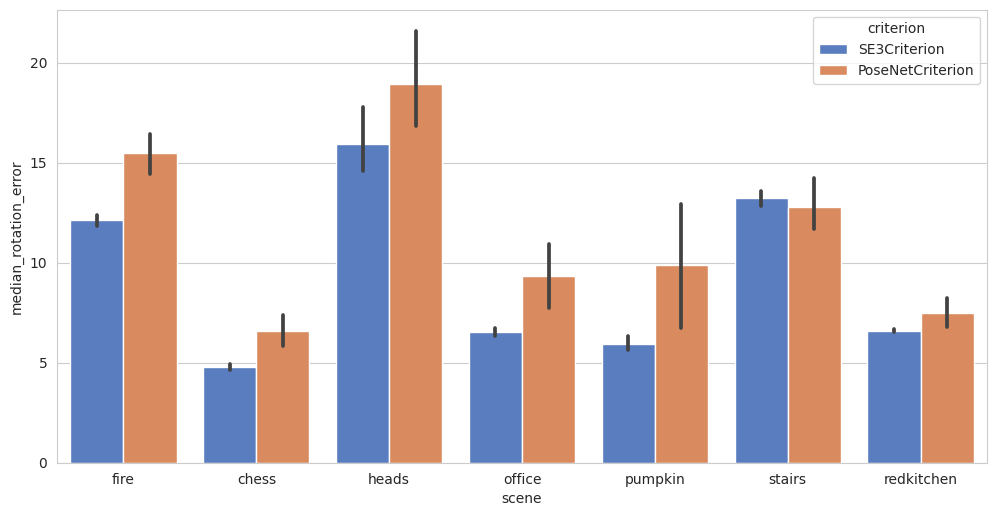

In [31]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
sns.barplot(x="scene", y="median_rotation_error", hue="criterion", data=data_20epoch, ax=ax)

<AxesSubplot:xlabel='scene', ylabel='median_position_error'>

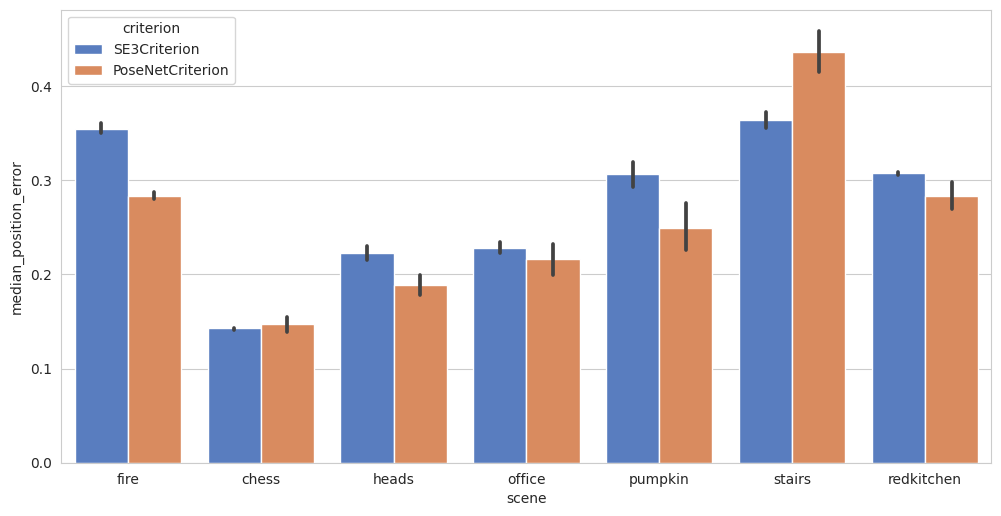

In [32]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
sns.barplot(x="scene", y="median_position_error", hue="criterion", data=data_20epoch, ax=ax)

In [33]:
low_epoch_result_data = data_20epoch.pivot_table(index=["scene"], 
                                         aggfunc=np.mean, 
                                         values=["median_rotation_error", "median_position_error"],
                                         columns=['criterion'])
low_epoch_result_data

median_position_error              median_rotation_error  \
criterion       PoseNetCriterion SE3Criterion      PoseNetCriterion   
scene                                                                 
chess                   0.147678     0.142690              6.603564   
fire                    0.283781     0.354253             15.461303   
heads                   0.188499     0.222607             18.936376   
office                  0.215992     0.228318              9.326130   
pumpkin                 0.249714     0.306203              9.892162   
redkitchen              0.283740     0.307359              7.488122   
stairs                  0.436697     0.363887             12.798755   

                         
criterion  SE3Criterion  
scene                    
chess          4.778714  
fire          12.127559  
heads         15.941476  
office         6.523015  
pumpkin        5.936006  
redkitchen     6.593758  
stairs        13.237672

In [34]:
result_data = data_20epoch.pivot_table(index=["scene", "criterion"], 
                                         aggfunc=np.mean, 
                                         values=["median_rotation_error", "median_position_error"])
result_data.pivot_table(index=["criterion"])

,median_position_error,median_rotation_error
criterion,,
PoseNetCriterion,0.258015,11.500916
SE3Criterion,0.275045,9.305457


## 100 epochs

<AxesSubplot:xlabel='scene', ylabel='median_rotation_error'>

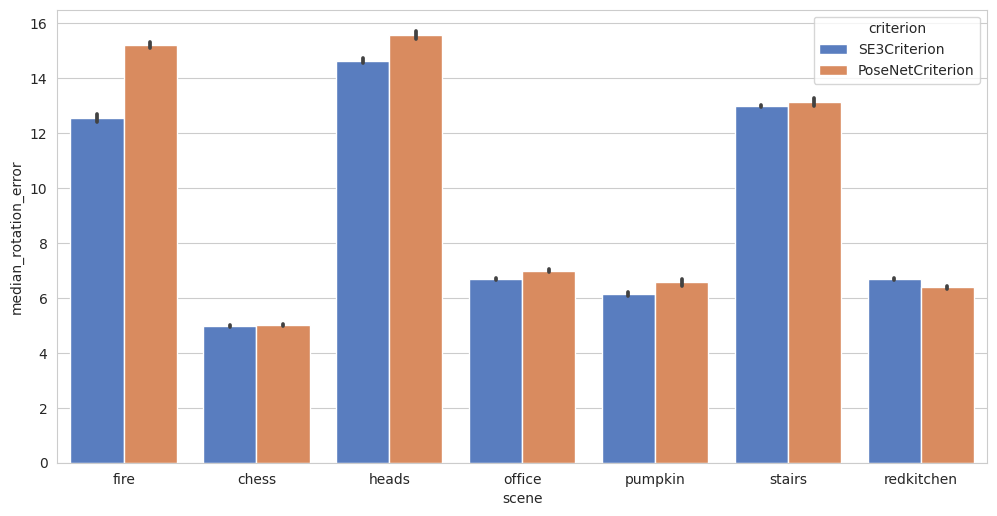

In [21]:
data = experiment_data[experiment_data["epoch"] > 80]
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
sns.barplot(x="scene", y="median_rotation_error", hue="criterion", data=data, ax=ax)

<AxesSubplot:xlabel='scene', ylabel='median_position_error'>

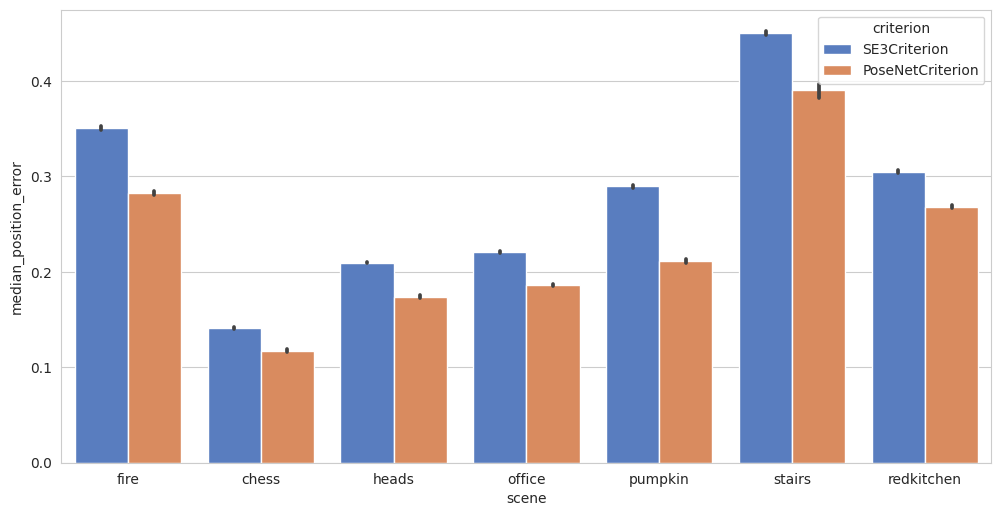

In [22]:
data = experiment_data[experiment_data["epoch"] > 80]
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
sns.barplot(x="scene", y="median_position_error", hue="criterion", data=data, ax=ax)

In [23]:
data = experiment_data[experiment_data["epoch"] > 80]
result_data = data.pivot_table(index=["scene", "criterion"], aggfunc=np.mean, values=["median_rotation_error", 
                                                                       "median_position_error"])
result_data
# data = data.applymap(lambda x: np.round(x, 3))

median_position_error  median_rotation_error
scene      criterion                                                     
chess      PoseNetCriterion               0.117377               5.010873
           SE3Criterion                   0.140976               4.969876
fire       PoseNetCriterion               0.282200              15.216749
           SE3Criterion                   0.350969              12.539901
heads      PoseNetCriterion               0.173814              15.565928
           SE3Criterion                   0.209621              14.635906
office     PoseNetCriterion               0.185890               6.992270
           SE3Criterion                   0.220744               6.689986
pumpkin    PoseNetCriterion               0.211812               6.567925
           SE3Criterion                   0.289402               6.130085
redkitchen PoseNetCriterion               0.268019               6.384517
           SE3Criterion                   0.304935               6.700925
stairs     PoseNetCriterion               0.390284              13.151490
           SE3Criterion                   0.450023              13.008915

In [24]:
result_data.pivot_table(index=["criterion"])

,median_position_error,median_rotation_error
criterion,,
PoseNetCriterion,0.232771,9.841393
SE3Criterion,0.280953,9.239371
